In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from scipy import linalg
from scipy.stats import norm
import random
import pandas as pd 


The Algorithm DSS (Denoising Source Seperation) Developed form:
http://jmlr.csail.mit.edu/papers/volume6/sarela05a/sarela05a.pdf
the algorithm is more effective than the averge neural network in determining the base signal 

In [2]:
def theshapeof(X):
    """Return the shape of X."""
    X = _check_data(X)
    # if not isinstance(X, np.ndarray):
    #     raise AttributeError('X must be a numpy array')

    if X.ndim == 3:
        return X.shape[0], X.shape[1], X.shape[2]
    elif X.ndim == 2:
        return X.shape[0], X.shape[1], 1
    elif X.ndim == 1:
        return X.shape[0], 1, 1
    else:
        raise ValueError("Array contains more than 3 dimensions")
        
def fold(X, epoch_size):
    """Fold 2D X into 3D."""
    if X.ndim > 2:
        raise AttributeError('X must be 2D at most')

    n_chans = X.shape[0] // epoch_size
    if X.shape[0] / epoch_size > 1:
        X = np.transpose(np.reshape(X, (epoch_size, n_chans, X.shape[1]),
                                    order="F").copy(), [0, 2, 1])
    return X


def unfold(X):
    """Unfold 3D X into 2D (concatenate trials)."""
    n_samples, n_chans, n_trials = theshapeof(X)

    if n_trials > 1:
        return np.reshape(
            np.transpose(X, (0, 2, 1)),
            (n_samples * n_trials, n_chans), order="F").copy()
    else:
        return X


def demean(X, weights=None, return_mean=False):
    """Remove weighted mean over columns (samples)."""
    weights = _check_weights(weights, X)

    n_samples, n_chans, n_trials = theshapeof(X)
    X = unfold(X)

    if weights.any():
        weights = unfold(weights)

        if weights.shape[0] != X.shape[0]:
            raise ValueError('X and weights arrays should have same ' +
                             'number of rows and pages.')

        if weights.shape[1] == 1 or weights.shape[1] == n_chans:
            the_mean = (np.sum(X * weights, axis=0) /
                        np.sum(weights, axis=0))[None, :]
        else:
            raise ValueError('Weight array should have either the same ' +
                             'number of columns as X array, or 1 column.')

        demeaned_X = X - the_mean
    else:
        the_mean = np.mean(X, axis=0, keepdims=True)
        demeaned_X = X - the_mean

    if n_trials > 1:
        demeaned_X = fold(demeaned_X, n_samples)

    if return_mean:
        return demeaned_X, the_mean  # the_mean.shape = (1, the_mean.shape[0])
    else:
        return demeaned_X

def rms(x, axis=0):
    """Root-mean-square along given axis."""
    return np.sqrt(np.mean(x ** 2, axis=axis, keepdims=True))

def pca(cov, max_components=None, thresh=0):
    """PCA rotation from covariance.

    Parameters
    ----------
    cov:  array, shape = (n_chans, n_chans)
        Covariance matrix.
    max_components : int | None
        Maximum number of components to retain after decomposition. ``None``
        (the default) keeps all suprathreshold components (see ``thresh``).

    Returns
    -------
    eigvecs: array, shape = (max_components, max_components)
        Eigenvectors (matrix of PCA components).
    eigenvalues: PCA eigenvalues

    """
    if not max_components:
        max_components = cov.shape[0]  # keep all components
    if thresh is not None and (thresh > 1 or thresh < 0):
        raise ValueError('Threshold must be between 0 and 1 (or None).')

    eigvals, eigvecs = linalg.eig(cov)

    eigvals = eigvals.real
    eigvecs = eigvecs.real

    idx = np.argsort(eigvals)[::-1]  # reverse sort ev order
    eigvals = eigvals[idx]

    # Truncate
    eigvecs = eigvecs[:, idx]
    eigvecs = eigvecs[:, np.arange(max_components)]
    eigvals = eigvals[np.arange(max_components)]

    if thresh is not None:
        suprathresh = np.where(eigvals / eigvals.max() > thresh)[0]
        eigvals = eigvals[suprathresh]
        eigvecs = eigvecs[:, suprathresh]

    return eigvecs, eigvals
def mean_over_trials(x, weights=None):
    """Compute mean over trials."""
    if weights is None:
        weights = np.array([])

    n_samples, n_chans, n_trials = theshapeof(x)

    if not weights.any():
        y = np.mean(x, 2)
        tw = np.ones((n_samples, n_chans, 1)) * n_trials
    else:
        m, n, o = theshapeof(weights)
        if m != n_samples:
            raise "!"
        if o != n_trials:
            raise "!"

        x = unfold(x)
        weights = unfold(weights)

        if n == n_chans:
            x = x * weights
            x = fold(x, n_samples)
            weights = fold(weights, n_samples)
            y = np.sum(x, 3) / np.sum(weights, 3)
        elif n == 1:
            x = x * weights
            x = fold(x, n_samples)
            weights = fold(weights, n_samples)
            y = np.sum(x, 3) * 1 / np.sum(weights, 3)

        tw = np.sum(weights, 3)

    return y, tw

def tscov(X, shifts=None, weights=None, assume_centered=True):
    """Time shift covariance.

    This function calculates, for each pair [X[i], X[j]] of columns of X, the
    cross-covariance matrix between the time-shifted versions of X[i].

    Parameters
    ----------
    X : array, shape = (n_times, n_chans[, n_trials])
        Data, can be 1D, 2D or 3D.
    shifts : array
        Array of time shifts.
    weights : array
        Weights, 1D (if X is 1D or 2D) or 2D (if X is 3D). The weights are not
        shifted.

    Returns
    -------
    C : array, shape = (n_channels * n_shifts, n_channels * n_shifts)
        Covariance matrix. This matrix is made up of a (n_times, n_times)
        matrix of submatrices of dimensions (n_shifts, n_shifts).
    tw : array
        Total weight (C/tw is the normalized covariance).

    """
    n_times, n_chans, n_trials = theshapeof(X)
    X = unsqueeze(X)

    weights = _check_weights(weights, X)
    shifts, n_shifts = _check_shifts(shifts)

    if not assume_centered:
        X = X - X.sum(0, keepdims=1) / n_chans

    if weights.any():  # weights
        X = np.einsum('ijk,ilk->ijk', X, weights)  # element-wise mult
        tw = np.sum(weights[:])
    else:  # no weights
        N = 0
        if len(shifts[shifts < 0]):
            N -= np.min(shifts)
        if len(shifts[shifts >= 0]):
            N += np.max(shifts)
        tw = (n_chans * n_shifts - N) * n_trials

    C = np.zeros((n_chans * n_shifts, n_chans * n_shifts))
    for trial in range(n_trials):
        XX = multishift(X[..., trial], shifts)
        XX = XX.reshape(n_times, n_chans * n_shifts)
        C += np.dot(XX.T, XX)

    return C, tw
def _check_data(X):
    """Check data is numpy array and has the proper dimensions."""
    if not isinstance(X, (np.ndarray, list)):
        raise AttributeError('data should be a list or a numpy array')

    dtype = np.complex128 if np.any(np.iscomplex(X)) else np.float64
    X = np.asanyarray(X, dtype=dtype)
    if X.ndim > 3:
        raise ValueError('Data must be 3D at most')

    return X
def unsqueeze(X):
    """Append singleton dimensions to an array."""
    X = _check_data(X)
    if X.shape != theshapeof(X):
        return X.reshape(theshapeof(X))
    else:
        return X
    
def _check_weights(weights, X):
    """Check weights dimensions against X."""
    if not isinstance(weights, (np.ndarray, list)):
        if weights is not None:
            warnings.warn('weights should be a list or a numpy array.')
        weights = np.array([])

    if len(weights) > 0:
        dtype = np.complex128 if np.any(np.iscomplex(weights)) else np.float64
        weights = np.asanyarray(weights, dtype=dtype)
        if weights.ndim > 3:
            raise ValueError('Weights must be 3D at most')
        if weights.shape[0] != X.shape[0]:
            raise ValueError("Weights should be the same n_times as X.")

        if X.ndim == 2 and weights.ndim == 1:
            weights = weights[:, np.newaxis]
        if X.ndim == 3 and weights.ndim == 2:
            weights = weights[:, np.newaxis, :]
        if X.ndim == 3 and weights.ndim == 1:
            weights = weights[:, np.newaxis, np.newaxis]

        if weights.shape[1] > 1:
            raise ValueError("Weights array should have a single column.")

    return weights

def _check_shifts(shifts):
    """Check shifts."""
    if not isinstance(shifts, (np.ndarray, list, np.integer, type(None))):
        raise AttributeError('shifts should be a list, an array or an int')
    if isinstance(shifts, (list, np.integer)):
        shifts = np.array(shifts).flatten()
    if shifts is None or len(shifts) == 0:
        shifts = np.array([0])
    n_shifts = np.size(shifts)
    return shifts, n_shifts

def multishift(X, shifts, fill_value=0, axis=0, keep_dims=False):
    """Apply several shifts along specified axis.

    If `shifts` has multiple values, the output will contain one shift per
    page. Shifted data are padded with `fill_value`.

    Parameters
    ----------
    X : array, shape = (n_samples[, n_epochs][, n_trials])
        Array to shift.
    shifts : array
        Array of shifts.
    fill_value : float | np.nan
        Value to pad output axis by.
    axis : int, optional
        The axis along which elements are shifted.
    keep_dims : bool
        If True, keep singleton dimensions in output.

    Returns
    -------
    y : array, shape = (n_samples[, n_epochs][, n_trials], n_shifts)
        Shifted array.

    See Also
    --------
    relshift, shift, shiftnd

    """
    shifts, n_shifts = _check_shifts(shifts)
    X = _check_data(X)

    # Loop over shifts
    y = np.zeros(X.shape + (n_shifts,))
    for i, s in enumerate(shifts):
            y[..., i] = shift(X, shift=s, fill_value=fill_value, axis=axis)

    if n_shifts == 1 and not keep_dims:
        y = np.squeeze(y, axis=-1)

    return y

def shift(X, shift, fill_value=0, axis=0):
    """Shift array along its first, second or last dimension.

    Output is padded by `fill_value`.

    Parameters
    ----------
    X : array, shape = (n_samples[, n_epochs][, n_trials])
        Multidimensional input array.
    shift : int
        The number of places by which elements are shifted along axis.
    fill_value : float
        Value to pad output axis by.
    axis : int, optional
        The axis along which elements are shifted.

    Returns
    -------
    y : array
        Output array, with the same shape as `X`.

    See Also
    --------
    relshift, multishift, shiftnd

    """
    if not np.equal(np.mod(shift, 1), 0):
        raise AttributeError('shift must be a single int')

    # reallocate empty array and assign slice.
    y = np.empty_like(X)

    if shift == 0:
        y[:] = X
    else:
        if axis == 0:
            if shift > 0:
                y[:shift, ...] = fill_value
                y[shift:, ...] = X[:-shift]
            elif shift < 0:
                y[shift:,  ...] = fill_value
                y[:shift,  ...] = X[-shift:]

        elif axis == 1:
            if shift > 0:
                y[:, :shift, ...] = fill_value
                y[:, shift:, ...] = X[:, :-shift]
            elif shift < 0:
                y[:, shift:,  ...] = fill_value
                y[:, :shift,  ...] = X[:, -shift:]

        elif axis == -1:
            if shift > 0:
                y[..., :shift] = fill_value
                y[..., shift:] = X[..., :-shift]
            elif shift < 0:
                y[..., shift:] = fill_value
                y[..., :shift] = X[..., -shift:]

        else:
            raise NotImplementedError('Axis must be 0, 1 or -1.')

    return y


In [3]:
def dss1(data, weights=None, keep1=None, keep2=1e-12):
    """DSS to maximise repeatability across trials.

    Evoked-biased DSS denoising.

    Parameters
    ----------
    data: array, shape = (n_samples, n_chans, n_trials)
        Data to denoise.
    weights: array
        Weights.
    keep1: int
        Number of PCs to retain in function:`dss0` (default: all).
    keep2: float
        Ignore PCs smaller than keep2 in function:`dss0` (default: 10^-12).

    Returns
    -------
    todss: array, shape = (n_dss_components, n_chans)
        Ddenoising matrix to convert data to normalized DSS components.
    pwr0: array
        Power per component (raw).
    pwr1: array
        Power per component (averaged).

    Notes
    -----
    The data mean is NOT removed prior to processing.

    """
    n_samples, n_chans, n_trials = theshapeof(data)
    data = demean(data, weights)  # remove weighted mean

    # weighted mean over trials (--> bias function for DSS)
    xx, ww = mean_over_trials(data, weights)

    ww = ww.min(1)

    # covariance of raw and biased data
    c0, nc0 = tscov(data, None, weights)
    c1, nc1 = tscov(xx, None, ww)
    c1 = c1 / n_trials

    todss, fromdss, ratio, pwr = dss0(c0, c1, keep1, keep2)

    return todss, fromdss, ratio, pwr


def dss0(c0, c1, keep1=None, keep2=1e-9):
    """DSS base function.

    This function allows specifying arbitrary bias functions (as compared to
    the function:`dss1`, which forces the bias to be the mean over trials).

    Parameters
    ----------
    c0: array, shape = (n_chans, n_chans)
        Baseline covariance.
    c1: array, shape = (n_chans, n_chans)
        Biased covariance.
    keep1: int
        Number of PCs to retain (default: all).
    keep2: float
        Ignore PCs smaller than keep2 (default: 10.^-9).

    Returns
    -------
    todss: array, shape = (n_dss_components, n_chans)
        Matrix to convert data to normalized DSS components.
    pwr0: array
        Power per component (baseline).
    pwr1: array
        Power per component (biased).

    """
    if c0 is None or c1 is None:
        raise AttributeError('dss0 needs at least two arguments')
    if c0.shape != c1.shape:
        raise AttributeError('c0 and c1 should have same size')
    if c0.shape[0] != c0.shape[1]:
        raise AttributeError('c0 should be square')
    if np.any(np.isnan(c0)) or np.any(np.isinf(c0)):
        raise ValueError('NaN or INF in c0')
    if np.any(np.isnan(c1)) or np.any(np.isinf(c1)):
        raise ValueError('NaN or INF in c1')

    # derive PCA and whitening matrix from unbiased covariance
    eigvec0, eigval0 = pca(c0, max_components=keep1, thresh=keep2)

    # apply whitening and PCA matrices to the biased covariance
    # (== covariance of bias whitened data)
    W = np.sqrt(1. / eigval0)  # diagonal of whitening matrix

    # c1 is projected into whitened PCA space of data channels
    c2 = (W * eigvec0.squeeze()).T.dot(c1).dot(eigvec0.squeeze()) * W

    # proj. matrix from whitened data space to a space maximizing bias
    eigvec2, eigval2 = pca(c2, max_components=keep1, thresh=keep2)

    # DSS matrix (raw data to normalized DSS)
    todss = (W[np.newaxis, :] * eigvec0).dot(eigvec2)
    fromdss = linalg.pinv(todss)

    # Normalise DSS matrix
    N = np.sqrt(1. / np.diag(np.dot(np.dot(todss.T, c0), todss)))
    todss = todss * N

    pwr0 = np.sqrt(np.sum(np.dot(c0, todss) ** 2, axis=0))
    pwr1 = np.sqrt(np.sum(np.dot(c1, todss) ** 2, axis=0))

    # Return data
    # next line equiv. to: np.array([np.dot(todss, ep) for ep in data])
    # dss_data = np.einsum('ij,hjk->hik', todss, data)

    return todss, fromdss, pwr0, pwr1


In [4]:
x=np.linspace(1, 10, 100)

In [5]:
#linear
def linear(m,c):
    y=m*x+c
    return y

#gaussian
def gaussian(mu,sigma,a):
    gu=((a * np.exp( - (x - mu)**2 / (2 * sigma**2) )))
    return gu

In [6]:
# genration of signals
#noisy 
def calcN():
    m=random.uniform(.1,2)
    mu=random.uniform(3,6)
    sigma=random.uniform(.1,2)
    c=random.uniform(0,3)
    a=random.uniform(-2,6)
    #noise=(np.random.normal(0,.0001,100))
    li=linear(m,c)
    gaus=gaussian(mu,sigma,a)
    sig=li+gaus
    return sig


In [19]:
#without noise
signal=[ calcN() for i in range(300)]


In [23]:
n_samples = 100 * 3
n_chans = 30
n_trials = 100
noise_dim = 20  # dimensionality of noise

# source
source = np.hstack((
    np.zeros((n_samples // 3,)),
    calcN(),
    np.zeros((n_samples // 3,))))[np.newaxis].T
s = source  # 300 * 30
s = s[:, :, np.newaxis]
s = np.tile(s, (1, 1, 100))

# noise
noise = np.dot(
    unfold(np.random.randn(n_samples, noise_dim, n_trials)),
    np.random.randn(noise_dim, n_chans))
noise = fold(noise, n_samples)

# mix signal and noise
SNR = 0.1
data = noise / rms(noise.flatten()) + SNR * s / rms(s.flatten())


In [24]:
c0, _ = tscov(data)
c1, _ = tscov(np.mean(data, 2))
[todss, _, pwr0, pwr1] = dss0(c0, c1)
z = fold(np.dot(unfold(data), todss), epoch_size=n_samples)

best_comp = np.mean(z[:, 0, :], -1)

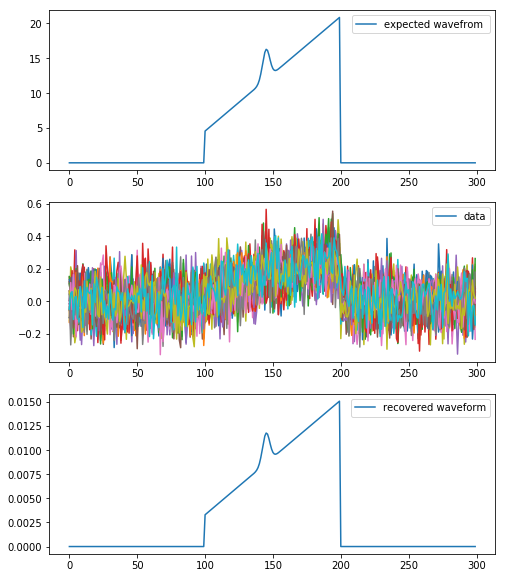

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
ax1.plot(source)
ax1.legend(['expected wavefrom ','' ])
ax2.plot(np.mean(data, 2))
ax2.legend(['data'])
ax3.plot(best_comp)
ax3.legend(['recovered waveform', ])
plt.show()

In [11]:
def calc():
    m=random.uniform(.1,2)
    mu=random.uniform(3,6)
    sigma=random.uniform(.1,2)
    c=random.uniform(0,3)
    a=random.uniform(-2,6)
    noise=(np.random.normal(0,.0001,100))
    li=linear(m,c)
    gaus=gaussian(mu,sigma,a)
    sig=li+gaus+noise
    return sig

def calc2():
    m=random.uniform(.1,2)
    mu=random.uniform(3,6)
    sigma=random.uniform(.1,2)
    c=random.uniform(0,3)
    a=random.uniform(-2,6)
    noise=(np.random.normal(0,.01,100))
    li=linear(m,c)
    gaus=gaussian(mu,sigma,a)
    sig=li+gaus+noise
    return sig

sign=[ calc() for i in range(300)]
dat=np.array(sign)
signf=[ calc2() for i in range(100)]
datf=np.array(signf)

In [12]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(100,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(100, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

Using TensorFlow backend.


In [13]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [14]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [15]:
x_train,x_test=np.split(dat,2)


In [16]:
x_train = x_train.astype('float32')/225
x_test = x_test.astype('float32')/225
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(150, 100)
(150, 100)


In [17]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=2,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 150 samples, validate on 150 samples
Epoch 1/10
150/150 [==============================] - 2s 12ms/step - loss: 0.6529 - val_loss: 0.5812
Epoch 2/10
150/150 [==============================] - 1s 5ms/step - loss: 0.3956 - val_loss: 0.2213
Epoch 3/10
150/150 [==============================] - 1s 6ms/step - loss: 0.1774 - val_loss: 0.1643
Epoch 4/10
150/150 [==============================] - 1s 3ms/step - loss: 0.1556 - val_loss: 0.1603
Epoch 5/10
150/150 [==============================] - 0s 3ms/step - loss: 0.1532 - val_loss: 0.1596
Epoch 6/10
150/150 [==============================] - 1s 4ms/step - loss: 0.1525 - val_loss: 0.1591
Epoch 7/10
150/150 [==============================] - 1s 6ms/step - loss: 0.1521 - val_loss: 0.1587
Epoch 8/10
150/150 [==============================] - 1s 7ms/step - loss: 0.1518 - val_loss: 0.1583
Epoch 9/10
150/150 [==============================] - 1s 6ms/step - loss: 0.1515 - val_loss: 0.1581
Epoch 10/10
150/150 [==============================] 

In [138]:
encoded_imgs = encoder.predict(datf)
decoded_imgs = decoder.predict(encoded_imgs)
